# Neural processes

In [1]:
import tensorflow as tf
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib import animation
import random
from IPython.display import HTML

%matplotlib inline

In [2]:
def encoder_h(inputs: tf.Tensor, n_hidden_units: int, dim_r: int) -> tf.Tensor :
    """Map inputs (x_i, y_i) to r_i"""
    hidden_outputs = tf.layers.dense(inputs, n_hidden_units, activation=tf.nn.sigmoid, name='encoder_layer1', reuse=tf.AUTO_REUSE, kernel_initializer='normal')
    r = tf.layers.dense(hidden_outputs, dim_r, name="encoder_layer2", reuse=tf.AUTO_REUSE, kernel_initializer='normal')
    return r

In [3]:
def aggregate_r(rs: tf.Tensor) -> tf.Tensor:
    """Aggregate the output of the encoder to a single representation"""
    mean = tf.reduce_mean(rs, axis=0)
    r = tf.reshape(mean, [1, -1])
    return r

In [4]:
GaussianParams = namedtuple('GaussianParams', ['mu', 'sigma'])

def get_z_params(input_r: tf.Tensor, dim_z: int) -> GaussianParams:
    mu = tf.layers.dense(input_r, dim_z, name="z_params_mu", reuse=tf.AUTO_REUSE, kernel_initializer='normal')
    
    sigma = tf.layers.dense(input_r, dim_z, name="z_params_sigma", reuse=tf.AUTO_REUSE, kernel_initializer='normal')
    sigma = tf.nn.softplus(sigma)
    
    return GaussianParams(mu, sigma)

In [5]:
def decoder_g(z_samples: tf.Tensor, x_star: tf.Tensor, n_hidden_units, noise_std: float=0.05) -> GaussianParams:
    """Determine output y* by decoding input and latent variable
    
    Parameters
    ----------
    z_samples
        Random samples from the latent variable distribution; shape: (n_draws, dim_z)
    x_star
        Input values to predict for
    n_hidden_units
        Number of hidden units used in decoder
    noise_std
        Constant standard deviation used on output
    
    Returns
    -------
        Parameters of Gaussian distributions for y*
    """
    # inputs dimensions
    # z_sample has dim [n_draws, dim_z]
    # x_star has dim [N_star, dim_x]

    n_draws = z_samples.get_shape().as_list()[0]
    n_xs = tf.shape(x_star)[0]
    
    # Repeat z samples for each x*
    z_samples_repeat = tf.expand_dims(z_samples, axis=1)
    z_samples_repeat = tf.tile(z_samples_repeat, [1, n_xs, 1])
    
    # Repeat x* for each z sample
    x_star_repeat = tf.expand_dims(x_star, axis=0)
    x_star_repeat = tf.tile(x_star_repeat, [n_draws, 1, 1])
    
    # Concatenate x* and z
    inputs = tf.concat([x_star_repeat, z_samples_repeat], axis=2)
    
    hidden = tf.layers.dense(inputs, n_hidden_units, activation=tf.nn.sigmoid, name="decoder_layer1", reuse=tf.AUTO_REUSE, kernel_initializer='normal')
    
    # mu will be of the shape [N_star, n_draws]
    mu_star = tf.layers.dense(hidden, 1, name="decoder_layer2", reuse=tf.AUTO_REUSE, kernel_initializer='normal')
    mu_star = tf.squeeze(mu_star, axis=2)
    mu_star = tf.transpose(mu_star)
    
    sigma_star = tf.constant(noise_std, dtype=tf.float32)

    return GaussianParams(mu_star, sigma_star)

In [6]:
def xy_to_z_params(xs: tf.Tensor, ys: tf.Tensor, n_hidden_units_h: int, dim_r: int, dim_z: int):
    xys = tf.concat([xs, ys], axis=1)
    rs = encoder_h(xys, n_hidden_units_h, dim_r)
    r = aggregate_r(rs)
    z_params = get_z_params(r, dim_z)
    return z_params

In [7]:
def KLqp_gaussian(mu_q, sigma_q, mu_p, sigma_p):
    sigma2_q = tf.square(sigma_q) + 1e-16
    sigma2_p = tf.square(sigma_p) + 1e-16
    temp = sigma2_q / sigma2_p + tf.square(mu_q - mu_p) / sigma2_p - 1.0 + tf.log(sigma2_p / sigma2_q + 1e-16)
    return 0.5 * tf.reduce_sum(temp)

In [8]:
def loglikelihood(y_star: tf.Tensor, y_pred_params: GaussianParams):
    p_normal = tf.distributions.Normal(loc=y_pred_params.mu, scale=y_pred_params.sigma)
    loglike = p_normal.log_prob(y_star)
    loglike = tf.reduce_sum(loglike, axis=0)
    loglike = tf.reduce_mean(loglike)
    return loglike

In [9]:
def init_neural_process(x_context, y_context, x_target, y_target, dim_r, dim_z, n_hidden_units_h: int, n_hidden_units_g: int, learning_rate=0.001, n_draws=7):
    # Concatenate context and target
    x_all = tf.concat([x_context, x_target], axis=0)
    y_all = tf.concat([y_context, y_target], axis=0)
    
    # Map input to z
    z_context = xy_to_z_params(x_context, y_context, n_hidden_units_h, dim_r, dim_z)
    z_all = xy_to_z_params(x_all, y_all, n_hidden_units_h, dim_r, dim_z)
    
    # Sample z
    epsilon = tf.random_normal([n_draws, dim_z])
    z_samples = tf.multiply(epsilon, z_all.sigma)
    z_samples = tf.add(z_samples, z_all.mu)
    
    # Map (z, x*) to y*
    y_pred_params = decoder_g(z_samples, x_target, n_hidden_units_g)
    
    # ELBO
    loglike = loglikelihood(y_target, y_pred_params)
    KL_loss = KLqp_gaussian(z_all.mu, z_all.sigma, z_context.mu, z_context.sigma)
    loss = tf.negative(loglike) + KL_loss
    
    # optimisation
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    
    return (train_op, loss)

## Experiment 1: Drawing from prior

In [10]:
def prior_predict(x_star_value: np.array, dim_z: int, n_hidden_units_g: int, epsilon: tf.Tensor=None, n_draws: int=1) -> GaussianParams:
    x_star = tf.constant(x_star_value, dtype=tf.float32)
    
    # the source of randomness can be optionally passed as an argument
    if epsilon is None:
        epsilon = tf.random_normal((n_draws, dim_z))
    z_sample = epsilon
    
    y_star = decoder_g(z_sample, x_star, n_hidden_units_g)
    return y_star

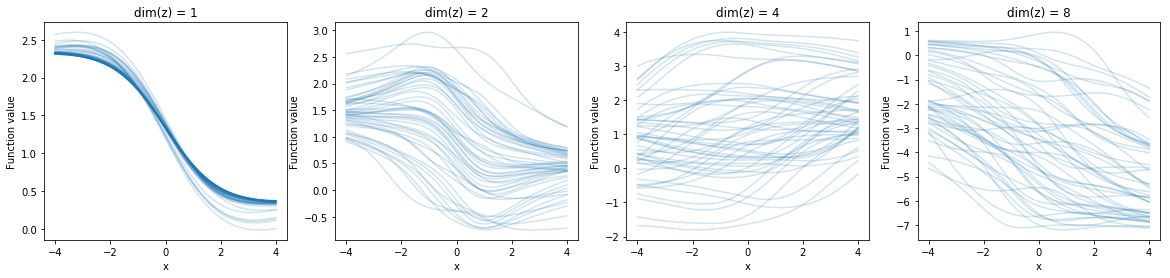

In [11]:
dim_r_values = [1, 2, 4, 8]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for dim_r_i in range(len(dim_r_values)):
    dim_r = dim_r_values[dim_r_i]

    dim_z = dim_r
    n_hidden_units_h = 8
    n_hidden_units_g = 8
    
    tf.reset_default_graph()

    sess = tf.Session()
    
    # Placeholders for training inputs
    x_context = tf.placeholder(tf.float32, (None, 1))
    y_context = tf.placeholder(tf.float32, (None, 1))
    x_target = tf.placeholder(tf.float32, (None, 1))
    y_target = tf.placeholder(tf.float32, (None, 1))
    
    # Set up NN
    train_op, loss = init_neural_process(x_context, y_context, x_target, y_target, dim_r, dim_z, n_hidden_units_h, n_hidden_units_g, learning_rate=0.001)
    
    # Initialise
    init = tf.global_variables_initializer()
    sess.run(init)
    
    x_star = np.linspace(-4, 4, 100)
    prior_predict_op = prior_predict(x_star.reshape((-1,1)), dim_z, n_hidden_units_g, n_draws=50)
    y_star_mat = sess.run(prior_predict_op.mu)
    for i in range(y_star_mat.shape[1]):
        axes[dim_r_i].plot(x_star, y_star_mat.T[i], c=cycle[0], alpha=0.2)
    axes[dim_r_i].set_title('dim(z) = {}'.format(dim_z))
    axes[dim_r_i].set_xlabel('x')

    axes[dim_r_i].set_ylabel('Function value')

plt.show()
    

## Experiment 2: training on simple dataset

In [12]:
def posterior_predict(x_value: np.array, y_value: np.array, x_star_value: np.array,
                      dim_r: int, dim_z: int, n_hidden_units_h: int, n_hidden_units_g: int,
                      epsilon: tf.Tensor=None, n_draws: int=1) -> GaussianParams:
    """Predict posterior function value conditioned on context
    
    Parameters
    ----------
    x_value
        Array of context input values; shape: (-1, 1)
    y_value
        Array of context output values; shape: (-1, 1)
    x_star_value
        Array of input values to predict for
    dim_r
        Dimension of encoded representation of context
    dim_z
        Dimension of latent variable
    n_hidden_units_h
        Number of hidden units used in encoder
    n_hidden_units_g
        Number of hidden units used in decoder
    epsilon
        Source of randomness for drawing samples from latent variable
    n_draws
        How many samples to draw from latent variable; ignored if epsilon is given
    """
    
    # Inputs for prediction time
    xs = tf.constant(x_value, dtype=tf.float32)
    ys = tf.constant(y_value, dtype=tf.float32)
    x_star = tf.constant(x_star_value, dtype=tf.float32)
    
    # For out-of-sample new points
    z_params = xy_to_z_params(xs, ys, n_hidden_units_h, dim_r, dim_z)
    
    # the source of randomness can be optionally passed as an argument
    if epsilon is None:
        epsilon = tf.random_normal((n_draws, dim_z))
    z_samples = tf.multiply(epsilon, z_params.sigma)
    z_samples = tf.add(z_samples, z_params.mu)

    y_star = decoder_g(z_samples, x_star, n_hidden_units_g)
    
    return y_star, z_params

In [13]:
def split_context_target(xs: np.array, ys: np.array, n_context: int,
                         x_context: tf.Tensor, y_context: tf.Tensor, x_target: tf.Tensor, y_target: tf.Tensor):
    indices = set(range(len(ys)))
    context_set_indices = set(random.sample(indices, n_context))
    target_set_indices = indices - context_set_indices
    
    return {
        x_context: xs[list(context_set_indices)].reshape((-1, 1)),
        y_context: ys[list(context_set_indices)].reshape((-1, 1)),
        x_target: xs[list(target_set_indices)].reshape((-1, 1)),
        y_target: ys[list(target_set_indices)].reshape((-1, 1))
    }

In [14]:
n_samples = 5
xs = np.linspace(-2, 2, n_samples)
ys = np.sin(xs)
n_draws = 200


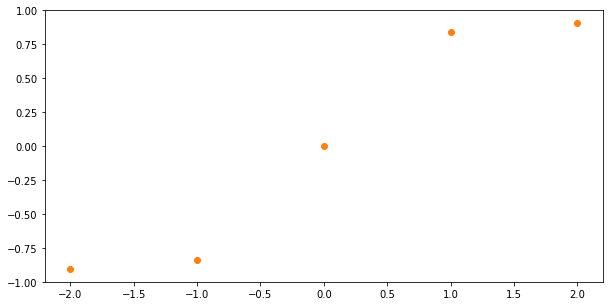

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
lns = [(plt.plot([], [], c=cycle[0], alpha=0.05, animated=True))[0] for _ in range(n_draws)]
target_sct = plt.scatter(xs, ys, c=cycle[1])

In [16]:
dim_r = 2
dim_z = 2
n_hidden_units_h = 8
n_hidden_units_g = 8

tf.reset_default_graph()

sess = tf.Session()

# Placeholders for training inputs
x_context = tf.placeholder(tf.float32, (None, 1))
y_context = tf.placeholder(tf.float32, (None, 1))
x_target = tf.placeholder(tf.float32, (None, 1))
y_target = tf.placeholder(tf.float32, (None, 1))

# Set up NN
train_op, loss = init_neural_process(x_context, y_context, x_target, y_target, dim_r, dim_z, n_hidden_units_h, n_hidden_units_g, learning_rate=0.001)

# Initialise
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 5000
plot_freq = 100

x_star = np.linspace(-10, 10, 100)
# (using fixed source of randomness over all iters)
eps_value = np.random.normal(size=(n_draws, dim_z))
epsilon = tf.constant(eps_value, dtype=tf.float32)
predict_op, predict_z_params = posterior_predict(xs.reshape((-1,1)), ys.reshape((-1, 1)), x_star.reshape((-1, 1)),
                                         dim_r, dim_z, n_hidden_units_h, n_hidden_units_g, epsilon)

pred_ys = []

from tqdm import tqdm_notebook

for i in tqdm_notebook(range(n_iter), desc="Training"):
    # Random number of context points
    n_context = random.choice(range(1, n_samples + 1))
    feed_dict = split_context_target(xs, ys, n_context, x_context, y_context, x_target, y_target)
    a = sess.run((train_op, loss), feed_dict=feed_dict)
    if i % plot_freq == 0:
        y_star_mat, z_mu_mat, z_sigma_mat = sess.run((predict_op.mu, predict_z_params.mu, predict_z_params.sigma))
        pred_ys.append(y_star_mat)

In [17]:
def init_animation():
    ax.set_xlim(-10.5, 10.5)
    ax.set_ylim(-2, 2)
    return lns

def update_animation(frame):
    for i in range(n_draws):
        lns[i].set_data(x_star, frame.T[i,:])
    return lns

anim = animation.FuncAnimation(fig, update_animation, frames=pred_ys, init_func=init_animation, blit=True)
HTML(anim.to_jshtml())